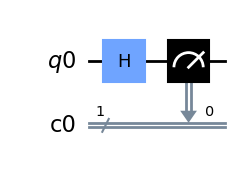

In [1]:
# simple quantum circuit run on simulator

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.measure(qr[0], cr[0])


qc.draw("mpl")

In [2]:
from qiskit_aer import AerSimulator

backend_sim = AerSimulator()
# run the circuit
rc = backend_sim.run(qc)
# get the results
rc = rc.result()
# retrieve the bitstring counts
counts = rc.get_counts()

print(f"Counts: {counts}")

Counts: {'0': 503, '1': 521}


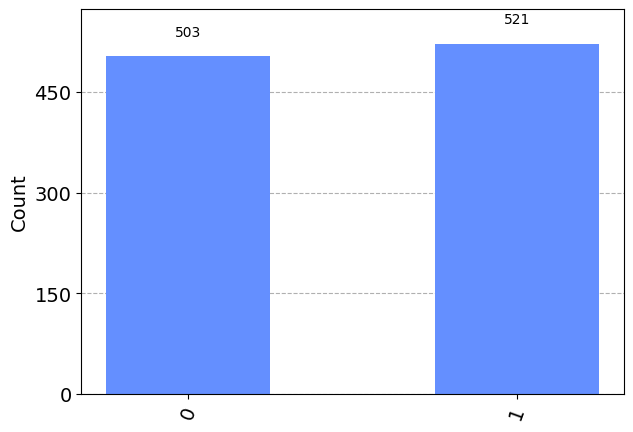

In [3]:
from qiskit.visualization import *

# plot histogram
plot_histogram(counts)

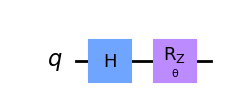

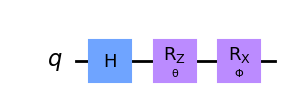

In [4]:
from qiskit.circuit import QuantumCircuit, Parameter
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)
display(qc_A.draw('mpl'))
# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)
display(qc_B.draw('mpl'))

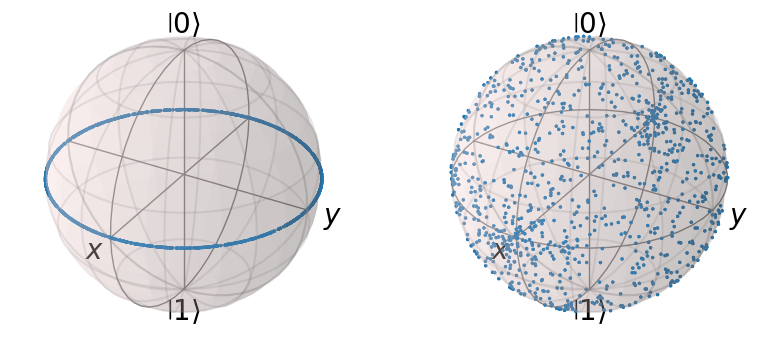

In [5]:
# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

## Quadratic Binary Optimization problems 

Combinatorial optimization problems are ubiquitous across many areas of science and application areas. 

- logistics, 
- scheduling, 
- planning, 
- portfolio optimization
- ...

Combinatorial optimization problems are problems involving a large number of yes/no decisions with each set of decisions yielding a corresponding objective function value, like a cost or profit value.

Because of the combinatorial explosion of the solution space with the number of variables, finding good solutions is extremely difficult.

The QUBO model unifies a rich variety of NP-hard combinatorial optimization problems:

- Quadratic Assignment Problems 
- Capital Budgeting Problems
- Task allocation Problems
- Maximum--Cut Problems

The QUBO objective function:

$$ F(q) = \sum_a v_a q_a + \sum_{a < b} \omega_{a b} q_a q_b $$
where $q_a \in \{0,1\}$, $v_a$ and $\omega_a$ are real coefficients for the linear and quadratic parts. 
The QUBO objective function is NP-hard in nature.

Let's change the variables: $$z_a = 2q_a-1$$ where $z \in {-1,1}$
$$F(z) = \sum_a h_a z_a + \sum_{a < b} J_{a b} z_a z_b $$ 

One popular method of encoding an optimization problem to be solved using QAOA, is to first formulate the problem as an `Ising Objective function`. The Ising model is a popular statistical mechanics model, associated primarily with ferromagnetism. Because it has been shown to be NP-Complete in nature, the objective function associated with it can be used to represent hard problems.

### Max-Cut

**Max-Cut** is an NP-complete problem, with applications in clustering, network science, and statistical physics. 

Given a graph $G(V,E)$, we seek partition of $V$ into two subsets with maximum cut. 

In short, we have to color every node either blue or red and we score a point whenever an edge connects two nodes with different colors. We then would like to find the solution with the highest score. 


<img src="img\qaoa_maxcut.png" height="300" >

Again, the problem in this specific graph coloring problem is that there are $2^N$ possible solutions for $N$ nodes (an exponential explosion in possibilities), making it impossible to enumerate all possible candidates for relevant system sizes.

The solution of Max-Cut, even if approximate, has practical application in machine scheduling, image recognition or for the layout of electronic circuits.

We can encode the `Maximum Cut` problem as a minimization problem of an Ising Hamiltonian, where the (classical) cost function reads:
$$ H_C = \sum_{a < b} J_{a b} z_a z_b $$ 

Ising matrix $J$ encoding the weights of the edges.

In short, the cost Hamiltonian assigns a number to every bitstring $z=(z_1,z_2,\dots,z_n)$
, and we would like to find the lowest number possible. This will be the optimal assignment and solution to our problem.


### QAOA proposition 

To approximate this groundstate, QAOA prepares a parametrized `ansatz state` (corresponding to a parameterized gate sequence), whose parameters are iteratively updated by a classical optimizer in a closed loop.

A good approximate solutions to the problem class considered here can be found by preparing the variational state:

$$ |\gamma \beta > = U_x(\beta_p) U_{zz}(\gamma_p) \dots U_x(\beta_1) U_{zz}(\gamma_1) |s> $$

where: 
$$U_x(\beta) = e^{-i \beta \hat{B}}$$
,

$$U_{zz}(\gamma) = e^{-i \gamma \hat{C}}$$

We start initially from a product of $\sigma^x$ eigenstates: 
$$|s> = |+> = \frac{1}{\sqrt{2}}(|0> + |1>)$$

The depth $p$ can be interpreted as a hyperparameter.

For $p$ layers of QAOA blocks, there are $2p$  classical parameters to optimize over, since each layer $k$ is characterized by just two variational parameters $\beta_k \in [0,\pi], \gamma_k \in [0,2\pi]$.

The next step is to find the optimal parameters $(\beta_{opt}, \gamma_{opt})$ such that the expectation value $$ <\beta_{opt},\gamma_{opt} | H | \beta_{opt},\gamma_{opt}>$$ is minimal

<img src="img/QAOA_schematic.png" width=400  >

## Code realization

Functional programming breaks down an application into a set of functions. 
Ideally, functions only take inputs and produce outputs and have no internal state that affects the output produced for a given input.

In that sense, the `QAOA algorithm` is a function that solves a `problem` by `optimize`ing a set of `params`. In other words, we aim to find the best values for these params.

To decide which params are best, we assess them based on the result we obtain from `compute`ing a (quantum) circuit that uses these params to encode the `problem` (problem_circuit) and its solution (ansatz_circuit).

This is what Qiskit’s description refers to as a variational algorithm. 

It uses a classical optimization algorithm that makes queries to a quantum computer.


In [6]:
def qaoa(problem, optimize, assess, compute,
  to_circuit, problem_circuit, ansatz_circuit):

    return optimize(
        lambda params: assess(problem, compute(to_circuit(problem, params,
              problem_circuit, ansatz_circuit)))
    )

In [7]:
from qiskit import Aer, execute

def compute(circuit):
    return execute(circuit, 
                   Aer.get_backend('qasm_simulator'), 
                   shots=1000).result().get_counts()

In [8]:
from qiskit import QuantumCircuit

def to_circuit(problem, params, problem_circuit, ansatz_circuit):
    
    cnt_qubits = problem.size
    
    qc_qaoa = QuantumCircuit(cnt_qubits)

    # initial_state
    qc_qaoa.h(range(cnt_qubits))
    
    # append problem circuit
    qc_qaoa.append(problem_circuit(problem, params[0]), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(problem, params[1]), range(cnt_qubits))
    qc_qaoa.measure_all()
    
    return qc_qaoa

In [9]:
def problem_circuit(problem, gamma):
    qc_p = QuantumCircuit(problem.size)
    for i, j in problem.relations:
        qc_p.rzz(gamma, i, j)
        qc_p.barrier()
    return qc_p

In [10]:
def ansatz_circuit(problem, beta):
    qc_a = QuantumCircuit(problem.size)
    for i in range(problem.size):
        qc_a.rx(beta, i)
    return qc_a

In [11]:
def assess(problem, result):
    avg = 0
    sum_count = 0
    for solution, count in result.items():
        performance = 0
        for i, j in problem.relations:
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count

In [12]:
from scipy.optimize import minimize

def optimize(f_params_to_problem):
    return minimize(
        # callable function
        f_params_to_problem,
        
        # initial guess on beta and gamma
        [1.0, 1.0],
        
        # optimization method
        method='COBYLA')

In [13]:
class Problem():
    def __init__(self, nodes, relations):
        self._nodes = nodes
        self._relations = relations
    
    @property
    def size(self) -> int:
        return len(self._nodes)
    
    @property
    def relations(self) -> list:
        return self._relations
    
    @property
    def nodes(self) -> list:
        return self._nodes

In [14]:
problem = Problem([0, 1, 2, 3], [(0, 1), (1, 2),(2,3),(3,0)])

result = qaoa(
  problem, optimize, assess, compute,
  to_circuit, problem_circuit, ansatz_circuit
)

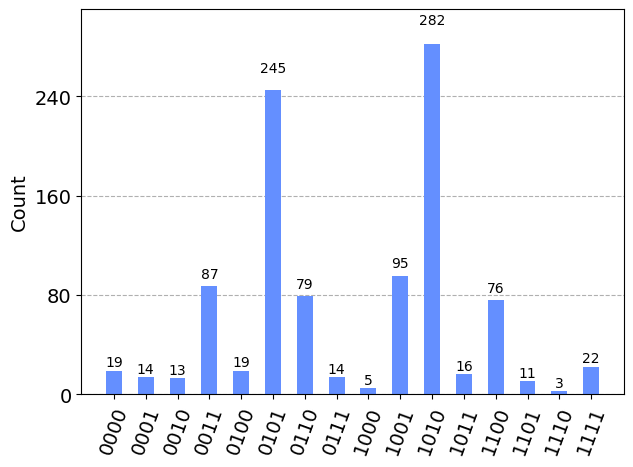

In [15]:
from qiskit.visualization import plot_histogram

plot_histogram(compute(to_circuit(
  problem, result.x, problem_circuit, ansatz_circuit
)))

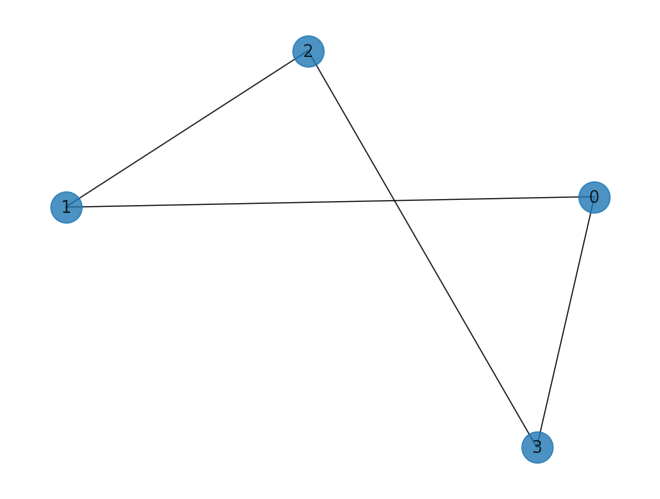

In [16]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

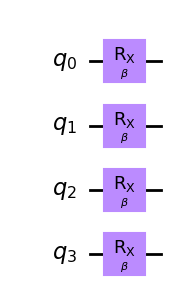

In [17]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(beta, i)

qc_mix.draw('mpl')

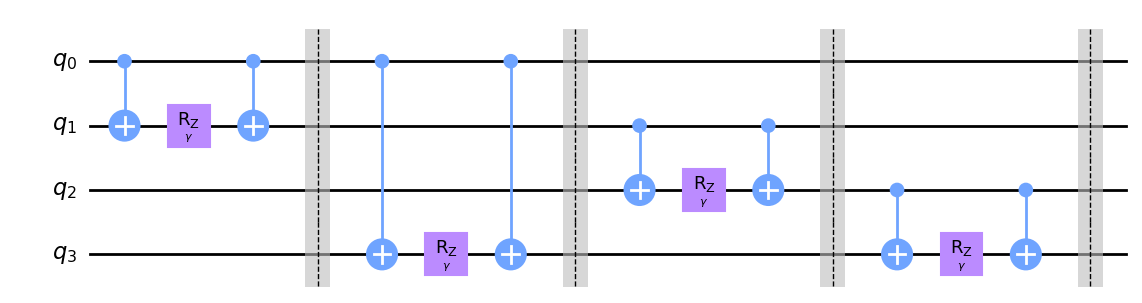

In [18]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw('mpl')

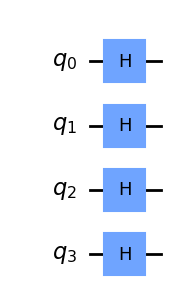

In [19]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw('mpl')

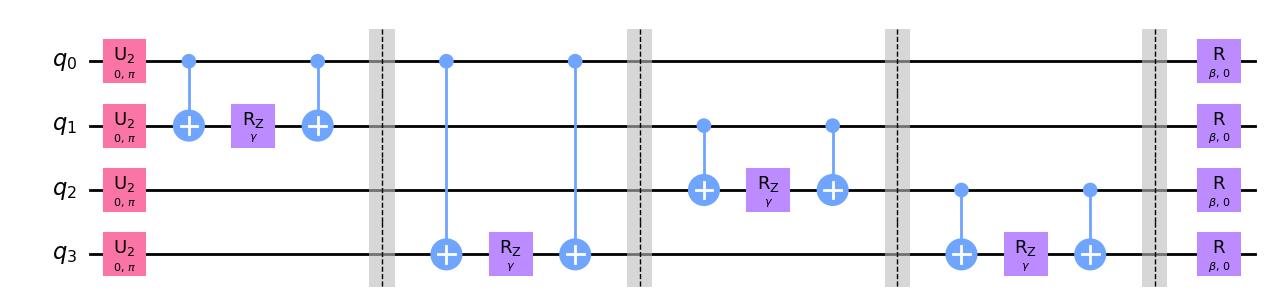

In [20]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl')

VQC

In [21]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split



iris = load_iris()
labels = iris.target

features = iris.data
features = MinMaxScaler().fit_transform(features)

df = pd.DataFrame(features, columns=iris.feature_names)
df['class'] = pd.Series(iris.target)

X = df.drop('class', axis=1).values
y = df['class'].values
num_features = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

/var/folders/_3/_nd7tv0d2gsfqkjz0fh2slbw0000gn/T/ipykernel_37646/2658134661.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:
# KODOWANIE DANYCH 
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

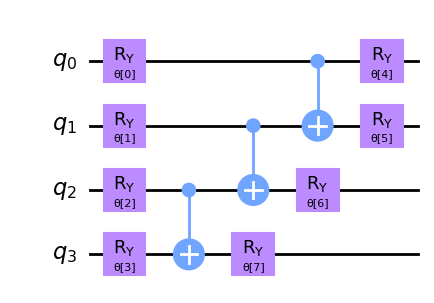

In [23]:

# WYBOR OBWODU PARAMETRYZOWANEGO JAKO MODEL ML 
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl")

In [24]:
# OPTYMALIZATOR i SAMPLER

from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

optimizer = COBYLA(maxiter=50)
sampler = Sampler()

In [25]:

from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

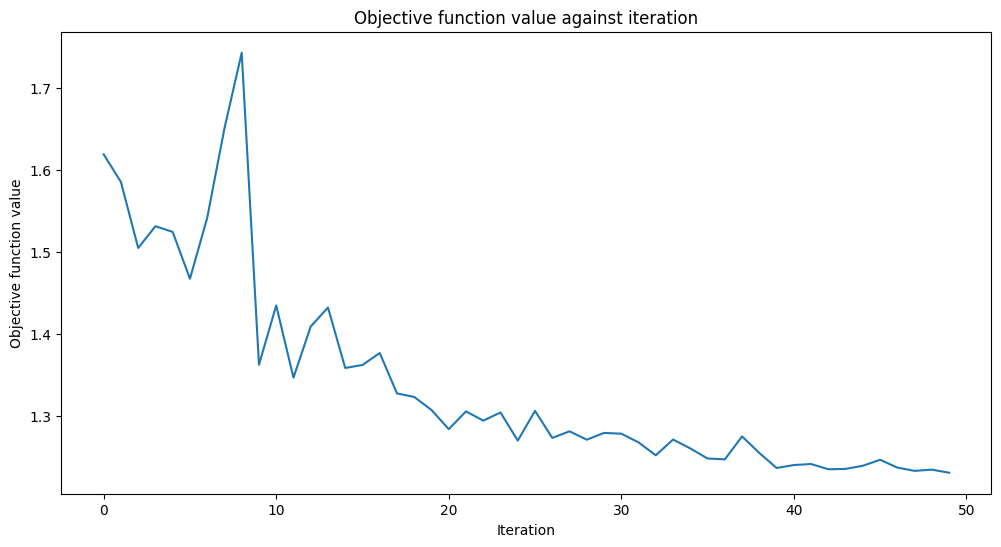

Czas uczenia: 17 sekund


In [26]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X, y)
elapsed = time.time() - start

print(f"Czas uczenia: {round(elapsed)} sekund")

In [27]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.47
